In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import numpy as np



# Prevents crashes when showing graphs
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
# plt.plot(np.array(val_darcy))
# plt.plot(np.array(darcy))
# plt.show()
# plt.plot(np.array(val_loss) - np.array(val_darcy))
# plt.plot(np.array(losses) - np.array(darcy))
# plt.show()

In [5]:
def vis(tensor):
    return tensor.cpu().detach().numpy()

def show_evaluation(model, indices, val_data):

    fig, axs = plt.subplots(len(indices), 6, dpi=600)

    axs[0,0].set_title("Given K", fontsize=8)
    axs[0,1].set_title("Predicted K",fontsize=8)
    axs[0,2].set_title("Actual K",fontsize=8)

    axs[0,3].set_title("Given Pres",fontsize=8)
    axs[0,4].set_title("Predicted Pres",fontsize=8)
    axs[0,5].set_title("Actual Pres",fontsize=8)

    for i,e in enumerate(indices):
        sample = val_data.__getitem__(e)
        out = model(sample[0].to(device).unsqueeze(0))[0]

        axs[i,0].imshow(vis(sample[0][0]), cmap='gray', vmin=0, vmax=255)
        axs[i,1].imshow(vis(out[0]), cmap='gray', vmin=0, vmax=255)
        axs[i,2].imshow(vis(sample[1][0]), cmap='gray', vmin=0, vmax=255)

        axs[i,3].imshow(vis(sample[0][1]), cmap='gray', vmin=0, vmax=255)
        axs[i,4].imshow(vis(out[1]), cmap='gray', vmin=0, vmax=255)
        axs[i,5].imshow(vis(sample[1][1]), cmap='gray', vmin=0, vmax=255)

    for axs in fig.get_axes():
        axs.axis('off')
    fig.tight_layout()
    plt.show()

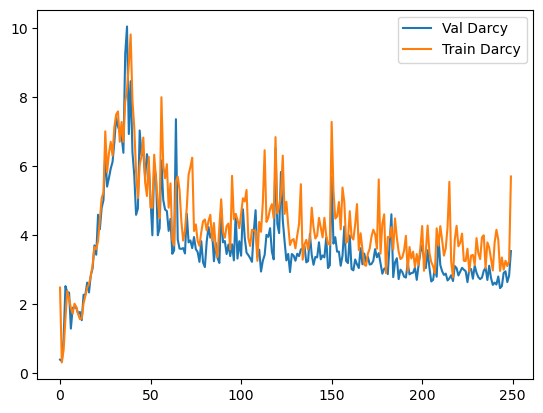

In [8]:
data = np.load("curves_disks_n8_r3_noise0.npz")
train_total = data["train_total"]
train_darcy = data["train_darcy"]
val_total   = data["val_total"]
val_darcy   = data["val_darcy"]

plt.plot(val_darcy, label="Val Darcy")
plt.plot(train_darcy, label="Train Darcy")
plt.legend()
plt.show()

In [ ]:
created = torch.load("disks_n8_r3_noise0.pt", weights_only=False).to(device)
show_evaluation(created, [9,2,12,17])

AttributeError: Can't get attribute 'SmallUnet' on <module '__main__'>